# 🚀 Enhanced Business ML Pipeline - Multiple Models Comparison

## Overview
This notebook implements a comprehensive machine learning pipeline for business analytics using multiple model types for comparison. The pipeline is based on actual available data columns without price data.

### Available Data Columns:
- **Uber**: Dispatching_base_num, Affiliated_base_num, locationID, pickup_date, pickup_time, pickup_day_of_week
- **Weather**: temperature, humidity, wind_speed, precipitation, pressure, date, hour, weather
- **Zones**: LocationID, Borough, Zone, service_zone, latitude, longitude

### Business Tasks:
1. **Location Demand Prediction** - Multiple regression models
2. **Peak Time Classification** - Multiple classification models
3. **Dispatching Base Performance Analysis** - Base efficiency prediction
4. **Weather-Demand Correlation** - Weather impact on trip volume

## 1. Import Libraries and Setup

In [31]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import os
import warnings
from datetime import datetime
import joblib
import json
import time

# ML Libraries with multiple model types
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.metrics import precision_score, recall_score, precision_recall_fscore_support

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Try XGBoost and LightGBM
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("📈 XGBoost available!")
except ImportError:
    XGB_AVAILABLE = False
    print("⚠️ XGBoost not available")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    print("🌟 LightGBM available!")
except ImportError:
    LGB_AVAILABLE = False
    print("⚠️ LightGBM not available")

warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

📈 XGBoost available!
🌟 LightGBM available!
✅ All libraries imported successfully!


## 2. Utility Functions for Visualization

In [32]:
def create_visualizations_dir():
    """Create visualizations directory if it doesn't exist"""
    viz_dir = "visualizations"
    if not os.path.exists(viz_dir):
        os.makedirs(viz_dir)
    return viz_dir

def plot_model_comparison(results, task_name, metric_name, viz_dir):
    """Create visualization comparing model performances"""
    plt.figure(figsize=(12, 8))
    
    models = list(results.keys())
    scores = [results[model][metric_name] for model in models if metric_name in results[model]]
    filtered_models = [model for model in models if metric_name in results[model]]
    
    if not scores:
        return
    
    # Create bar plot
    bars = plt.bar(filtered_models, scores, alpha=0.7, color='skyblue', edgecolor='navy', linewidth=1.2)
    
    # Highlight best model
    if metric_name in ['MAE', 'MSE']:  # Lower is better
        best_idx = scores.index(min(scores))
    else:  # Higher is better
        best_idx = scores.index(max(scores))
    bars[best_idx].set_color('lightcoral')
    
    plt.title(f'{task_name} - {metric_name} Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Models', fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (max(scores) * 0.01),
                f'{score:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    filename = f"{viz_dir}/{task_name.replace(' ', '_').lower()}_{metric_name.lower()}_comparison.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📊 Saved visualization: {filename}")

def plot_confusion_matrix_heatmap(y_true, y_pred, task_name, model_name, viz_dir):
    """Create confusion matrix heatmap"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'{task_name} - {model_name}\nConfusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    
    filename = f"{viz_dir}/{task_name.replace(' ', '_').lower()}_{model_name.lower()}_confusion_matrix.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"📊 Saved confusion matrix: {filename}")

def plot_feature_importance(model, feature_names, task_name, model_name, viz_dir, top_n=15):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]
        
        plt.figure(figsize=(10, 8))
        plt.title(f'{task_name} - {model_name}\nTop {top_n} Feature Importances', fontsize=14, fontweight='bold')
        plt.barh(range(top_n), importances[indices][::-1], alpha=0.7, color='lightgreen', edgecolor='darkgreen')
        plt.yticks(range(top_n), [feature_names[i] for i in indices[::-1]])
        plt.xlabel('Feature Importance', fontsize=12)
        plt.grid(axis='x', alpha=0.3)
        
        filename = f"{viz_dir}/{task_name.replace(' ', '_').lower()}_{model_name.lower()}_feature_importance.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"📊 Saved feature importance: {filename}")

print("✅ Visualization functions defined!")

✅ Visualization functions defined!


## 3. Enhanced Business Pipeline Class Definition

In [33]:
class EnhancedBusinessPipeline:
    """
    Enhanced Business ML Pipeline with Multiple Model Comparison
    
    Business Tasks (Based on Real Data):
    1. Location Demand Prediction (Regression) - Predict trip volume per location/hour
    2. Peak Time Classification - Classify rush hour vs normal time
    3. Dispatching Base Performance Analysis - Predict base efficiency  
    4. Weather-Demand Correlation - Predict weather impact on demand
    """
    
    def __init__(self):
        self.models = {}
        self.best_models = {}
        self.scalers = {}
        self.encoders = {}
        self.feature_columns = {}
        self.model_performances = {}
        self.viz_dir = create_visualizations_dir()
        
        print(f"🔧 Enhanced Pipeline initialized")
        print(f"📈 XGBoost Available: {XGB_AVAILABLE}")
        print(f"🌟 LightGBM Available: {LGB_AVAILABLE}")
        print(f"📊 Visualizations directory: {self.viz_dir}")

print("✅ Pipeline class defined!")

✅ Pipeline class defined!


## 4. Data Loading and Preparation Methods

In [34]:
# Add data loading methods to the pipeline class
def load_csv_data(self):
    """Load data from CSV files"""
    print("📊 Loading data from CSV files...")
    
    # Load data
    uber_data = pd.read_csv('database/uber_trips_processed.csv')
    weather_data = pd.read_csv('database/weather_data_cleaned.csv') 
    taxi_zones = pd.read_csv('database/taxi_zone_lookup_coordinates.csv')
    
    print(f"✅ Loaded {len(uber_data)} uber trips")
    print(f"✅ Loaded {len(weather_data)} weather records") 
    print(f"✅ Loaded {len(taxi_zones)} taxi zones")
    
    return uber_data, weather_data, taxi_zones

def prepare_features(self, uber_data, weather_data, taxi_zones):
    """Prepare features based on ACTUAL available columns"""
    print("🔧 Preparing features...")
    
    # Sample data for faster processing
    if len(uber_data) > 300000:
        print(f"📊 Sampling {300000} records from {len(uber_data)} for faster processing...")
        uber_data = uber_data.sample(n=300000, random_state=42).reset_index(drop=True)
    
    # Convert datetime columns
    if 'pickup_date' in uber_data.columns:
        uber_data['pickup_date'] = pd.to_datetime(uber_data['pickup_date'], errors='coerce')
    
    # Extract hour from pickup_time
    if 'pickup_time' in uber_data.columns:
        print("🕐 Extracting hour from pickup_time...")
        uber_data['pickup_time'] = pd.to_datetime(uber_data['pickup_time'], errors='coerce')
        uber_data['hour'] = uber_data['pickup_time'].dt.hour
        print(f"✅ Created hour column with values: {uber_data['hour'].min()}-{uber_data['hour'].max()}")
    
    # Prepare weather data
    if 'date' in weather_data.columns:
        weather_data['date'] = pd.to_datetime(weather_data['date'], errors='coerce')
    
    print(f"🔍 Uber columns: {list(uber_data.columns)}")
    print(f"🔍 Weather columns: {list(weather_data.columns)}")
    
    # Merge with weather data
    try:
        uber_data_merged = uber_data.merge(
            weather_data, 
            left_on=['pickup_date', 'hour'], 
            right_on=['date', 'hour'], 
            how='left',
            suffixes=('', '_weather')
        )
        print(f"✅ Successfully merged with weather data: {uber_data_merged.shape}")
    except Exception as e:
        print(f"❌ Merge failed: {e}")
        uber_data_merged = uber_data
    
    # Merge with taxi zones for borough info
    uber_data_final = uber_data_merged.merge(
        taxi_zones[['LocationID', 'Borough', 'latitude', 'longitude']].rename(columns={'LocationID': 'locationID'}),
        on='locationID',
        how='left'
    )
    
    print(f"✅ Final dataset shape: {uber_data_final.shape}")
    print(f"✅ Available columns: {list(uber_data_final.columns)}")
    
    return uber_data_final

# Add methods to the pipeline class
EnhancedBusinessPipeline.load_csv_data = load_csv_data
EnhancedBusinessPipeline.prepare_features = prepare_features

print("✅ Data loading methods added to pipeline class!")

✅ Data loading methods added to pipeline class!


## 5. Model Definition Methods

In [35]:
def get_regression_models(self):
    """Get multiple regression models for comparison"""
    models = {}
    
    # Traditional models
    models['RandomForest'] = RandomForestRegressor(
        n_estimators=100, max_depth=10, min_samples_split=10, 
        min_samples_leaf=5, random_state=42
    )
    
    models['GradientBoosting'] = GradientBoostingRegressor(
        n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42
    )
    
    models['ExtraTrees'] = ExtraTreesRegressor(
        n_estimators=100, max_depth=10, min_samples_split=10, random_state=42
    )
    
    models['Ridge'] = Ridge(alpha=1.0, random_state=42)
    models['Lasso'] = Lasso(alpha=1.0, random_state=42)
    models['ElasticNet'] = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
    models['SVR'] = SVR(kernel='rbf', C=1.0, gamma='scale')
    models['KNN'] = KNeighborsRegressor(n_neighbors=5)
    models['DecisionTree'] = DecisionTreeRegressor(max_depth=10, min_samples_split=10, random_state=42)
    
    # Neural Network
    models['MLPRegressor'] = MLPRegressor(
        hidden_layer_sizes=(100, 50), 
        max_iter=500, 
        random_state=42, 
        early_stopping=True,
        validation_fraction=0.1,
        alpha=0.01
    )
    
    # Advanced models if available
    if XGB_AVAILABLE:
        models['XGBoost'] = xgb.XGBRegressor(
            n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42
        )
    
    if LGB_AVAILABLE:
        models['LightGBM'] = lgb.LGBMRegressor(
            n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1
        )
    
    return models

def get_classification_models(self):
    """Get multiple classification models for comparison"""
    models = {}
    
    # Traditional models
    models['RandomForest'] = RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=10, 
        min_samples_leaf=5, random_state=42
    )
    
    models['GradientBoosting'] = GradientBoostingClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42
    )
    
    models['ExtraTrees'] = ExtraTreesClassifier(
        n_estimators=100, max_depth=10, min_samples_split=10, random_state=42
    )
    
    models['LogisticRegression'] = LogisticRegression(
        C=1.0, random_state=42, max_iter=1000
    )
    models['SVC'] = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    models['KNN'] = KNeighborsClassifier(n_neighbors=5)
    models['NaiveBayes'] = GaussianNB()
    models['DecisionTree'] = DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=42)
    
    # Neural Network
    models['MLPClassifier'] = MLPClassifier(
        hidden_layer_sizes=(100, 50), 
        max_iter=500, 
        random_state=42, 
        early_stopping=True,
        validation_fraction=0.1,
        alpha=0.01
    )
    
    # Advanced models if available
    if XGB_AVAILABLE:
        models['XGBoost'] = xgb.XGBClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42
        )
    
    if LGB_AVAILABLE:
        models['LightGBM'] = lgb.LGBMClassifier(
            n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1
        )
    
    return models

# Add methods to the pipeline class
EnhancedBusinessPipeline.get_regression_models = get_regression_models
EnhancedBusinessPipeline.get_classification_models = get_classification_models

print("✅ Model definition methods added to pipeline class!")

✅ Model definition methods added to pipeline class!


## 6. Model Evaluation Methods

In [36]:
def evaluate_regression_models(self, models, X_train, X_test, y_train, y_test, task_name):
    """Evaluate multiple regression models and return the best one"""
    print(f"\n🔄 Evaluating {len(models)} regression models for {task_name}...")
    
    results = {}
    best_model = None
    best_mae = float('inf')
    best_model_name = ""
    
    for name, model in models.items():
        try:
            start_time = time.time()
            
            # Train model
            model.fit(X_train, y_train)
            
            # Predict
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            training_time = time.time() - start_time
            
            results[name] = {
                'MAE': mae,
                'MSE': mse,
                'R2': r2,
                'Training_Time': training_time
            }
            
            print(f"📊 {name:15} - MAE: {mae:.3f}, MSE: {mse:.3f}, R²: {r2:.3f}, Time: {training_time:.2f}s")
            
            if mae < best_mae:
                best_mae = mae
                best_model = model
                best_model_name = name
                
        except Exception as e:
            print(f"❌ {name} failed: {str(e)[:50]}...")
            results[name] = {'Error': str(e)}
    
    print(f"🏆 Best model: {best_model_name} with MAE: {best_mae:.3f}")
    
    # Generate visualizations for regression models
    if best_model is not None:
        try:
            # Plot model comparison
            plot_model_comparison(results, task_name, 'MAE', self.viz_dir)
            plot_model_comparison(results, task_name, 'R2', self.viz_dir)
            
            # Plot feature importance if available
            if hasattr(X_train, 'columns'):
                feature_names = X_train.columns.tolist()
            elif isinstance(X_train, np.ndarray):
                feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]
            else:
                feature_names = [f'Feature_{i}' for i in range(len(X_train[0]))]
            
            # plot_feature_importance(best_model, feature_names, task_name, best_model_name, self.viz_dir)
            
        except Exception as e:
            print(f"⚠️ Visualization error: {str(e)[:50]}...")
    
    return best_model, best_model_name, results

def evaluate_classification_models(self, models, X_train, X_test, y_train, y_test, task_name):
    """Evaluate multiple classification models and return the best one"""
    print(f"\n🔄 Evaluating {len(models)} classification models for {task_name}...")
    
    results = {}
    best_model = None
    best_f1 = 0
    best_model_name = ""
    
    for name, model in models.items():
        try:
            start_time = time.time()
            
            # Train model
            model.fit(X_train, y_train)
            
            # Predict
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            
            training_time = time.time() - start_time
            
            results[name] = {
                'Accuracy': accuracy,
                'F1': f1,
                'Precision': precision,
                'Recall': recall,
                'Training_Time': training_time
            }
            
            print(f"📊 {name:15} - Acc: {accuracy:.3f}, F1: {f1:.3f}, Prec: {precision:.3f}, Rec: {recall:.3f}, Time: {training_time:.2f}s")
            
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                best_model_name = name
                
        except Exception as e:
            print(f"❌ {name} failed: {str(e)[:50]}...")
            results[name] = {'Error': str(e)}
    
    print(f"🏆 Best model: {best_model_name} with F1: {best_f1:.3f}")
    
    # Generate visualizations for best model
    if best_model is not None:
        try:
            # Plot model comparison
            plot_model_comparison(results, task_name, 'F1', self.viz_dir)
            plot_model_comparison(results, task_name, 'Accuracy', self.viz_dir)
            plot_model_comparison(results, task_name, 'Precision', self.viz_dir)
            plot_model_comparison(results, task_name, 'Recall', self.viz_dir)
            
            # Plot confusion matrix for best model
            y_pred_best = best_model.predict(X_test)
            plot_confusion_matrix_heatmap(y_test, y_pred_best, task_name, best_model_name, self.viz_dir)
            
            # Plot feature importance if available
            if hasattr(X_train, 'columns'):
                feature_names = X_train.columns.tolist()
            elif isinstance(X_train, np.ndarray):
                feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]
            else:
                feature_names = [f'Feature_{i}' for i in range(len(X_train[0]))]
            
            # plot_feature_importance(best_model, feature_names, task_name, best_model_name, self.viz_dir)
            
        except Exception as e:
            print(f"⚠️ Visualization error: {str(e)[:50]}...")
    
    return best_model, best_model_name, results

# Add methods to the pipeline class
EnhancedBusinessPipeline.evaluate_regression_models = evaluate_regression_models
EnhancedBusinessPipeline.evaluate_classification_models = evaluate_classification_models

print("✅ Model evaluation methods added to pipeline class!")

✅ Model evaluation methods added to pipeline class!


## 7. Business Task Methods

### Task 1: Location Demand Prediction
Predicts trip volume per location/hour using multiple regression models.

### Task 2: Peak Time Classification
Classifies rush hour vs normal time using multiple classification models.

### Task 3: Dispatching Base Performance Analysis
Predicts which dispatching bases are most efficient.

### Task 4: Weather-Demand Correlation
Predicts trip demand based on weather conditions.

In [37]:
def task1_location_demand_prediction(self, df):
    """
    🎯 Task 1: Location Demand Prediction (Regression)
    Multiple models comparison for predicting trip volume per location/hour
    """
    print("\n🎯 Task 1: Location Demand Prediction")
    print("=" * 50)
    
    # Create demand data by aggregating trips per location/hour
    demand_data = df.groupby(['locationID', 'hour', 'pickup_day_of_week']).agg({
        'pickup_date': 'count',  # Trip count
        'temperature': 'mean',
        'humidity': 'mean', 
        'wind_speed': 'mean',
        'precipitation': 'mean'
    }).reset_index()
    
    demand_data.rename(columns={'pickup_date': 'trip_count'}, inplace=True)
    demand_data = demand_data.dropna()
    
    if len(demand_data) < 100:
        print("❌ Insufficient data for location demand prediction")
        return None
    
    # Features and target
    feature_cols = ['locationID', 'hour', 'pickup_day_of_week', 'temperature', 
                   'humidity', 'wind_speed', 'precipitation']
    X = demand_data[feature_cols].fillna(0)
    y = demand_data['trip_count']
    
    # Encode categorical variables
    le_day = LabelEncoder()
    X['pickup_day_of_week_encoded'] = le_day.fit_transform(X['pickup_day_of_week'].astype(str))
    
    # Use encoded features
    feature_cols_encoded = ['locationID', 'hour', 'pickup_day_of_week_encoded', 'temperature', 
                           'humidity', 'wind_speed', 'precipitation']
    X_encoded = X[feature_cols_encoded]
    
    # Time-based split
    split_point = int(len(X_encoded) * 0.8)
    X_train, X_test = X_encoded[:split_point], X_encoded[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    
    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Get and evaluate multiple models
    models = self.get_regression_models()
    best_model, best_name, results = self.evaluate_regression_models(
        models, X_train_scaled, X_test_scaled, y_train, y_test, "Location Demand Prediction"
    )
    
    # Save best model and results
    self.best_models['location_demand'] = {
        'model': best_model,
        'name': best_name,
        'scaler': scaler,
        'encoder': le_day,
        'features': feature_cols_encoded
    }
    self.model_performances['location_demand'] = results
    
    return best_model

# Add method to pipeline class
EnhancedBusinessPipeline.task1_location_demand_prediction = task1_location_demand_prediction
print("✅ Task 1 method added to pipeline class!")

✅ Task 1 method added to pipeline class!


In [38]:
def task2_peak_time_classification(self, df):
    """
    🎯 Task 2: Peak Time Classification
    Multiple models comparison for classifying peak vs normal hours
    """
    print("\n🎯 Task 2: Peak Time Classification")
    print("=" * 50)
    
    # Create peak time labels based on trip density
    hourly_trips = df.groupby(['hour', 'pickup_day_of_week']).size().reset_index(name='trip_count')
    
    # Define peak hours (top 25% of trip volumes)
    peak_threshold = hourly_trips['trip_count'].quantile(0.75)
    hourly_trips['is_peak'] = (hourly_trips['trip_count'] >= peak_threshold).astype(int)
    
    # Merge back with original data (sample for performance)
    df_sample = df.sample(n=min(50000, len(df)), random_state=42)
    df_with_peak = df_sample.merge(hourly_trips[['hour', 'pickup_day_of_week', 'is_peak']], 
                                  on=['hour', 'pickup_day_of_week'], how='left')
    
    # Features and target
    feature_cols = ['hour', 'pickup_day_of_week', 'temperature', 'humidity', 
                   'wind_speed', 'precipitation']
    
    X = df_with_peak[feature_cols].fillna(0)
    y = df_with_peak['is_peak'].fillna(0)
    
    # Encode categorical variables
    le_day = LabelEncoder()
    X['pickup_day_of_week_encoded'] = le_day.fit_transform(X['pickup_day_of_week'].astype(str))
    
    # Use encoded features
    feature_cols_encoded = ['hour', 'pickup_day_of_week_encoded', 'temperature', 'humidity', 
                           'wind_speed', 'precipitation']
    X_encoded = X[feature_cols_encoded]
    
    # Time-based split
    split_point = int(len(X_encoded) * 0.8)
    X_train, X_test = X_encoded[:split_point], X_encoded[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    
    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Get and evaluate multiple models
    models = self.get_classification_models()
    best_model, best_name, results = self.evaluate_classification_models(
        models, X_train_scaled, X_test_scaled, y_train, y_test, "Peak Time Classification"
    )
    
    # Save best model and results
    self.best_models['peak_time'] = {
        'model': best_model,
        'name': best_name,
        'scaler': scaler,
        'encoder': le_day,
        'features': feature_cols_encoded
    }
    self.model_performances['peak_time'] = results
    
    return best_model

# Add method to pipeline class
EnhancedBusinessPipeline.task2_peak_time_classification = task2_peak_time_classification
print("✅ Task 2 method added to pipeline class!")

✅ Task 2 method added to pipeline class!


In [39]:
def task3_dispatching_base_performance(self, df):
    """
    🎯 Task 3: Dispatching Base Performance Analysis
    Multiple models to predict which dispatching bases are most efficient
    """
    print("\n🎯 Task 3: Dispatching Base Performance Analysis")
    print("=" * 50)
    
    # Create base performance data
    base_performance = df.groupby(['Dispatching_base_num', 'hour', 'pickup_day_of_week']).agg({
        'locationID': ['count', 'nunique'],  # Trip count and unique locations
        'temperature': 'mean',
        'humidity': 'mean'
    }).reset_index()
    
    # Flatten column names
    base_performance.columns = ['Dispatching_base_num', 'hour', 'pickup_day_of_week', 
                              'trip_count', 'locations_served', 'temperature', 'humidity']
    
    # Calculate efficiency score (trips per location)
    base_performance['efficiency_score'] = (
        base_performance['trip_count'] / base_performance['locations_served']
    ).fillna(0)
    
    # Create efficiency categories (High/Medium/Low)
    base_performance['efficiency_category'] = pd.cut(
        base_performance['efficiency_score'], 
        bins=3, 
        labels=['Low', 'Medium', 'High']
    )
    
    base_performance = base_performance.dropna()
    
    if len(base_performance) < 100:
        print("❌ Insufficient data for base performance analysis")
        return None
    
    # Features and target
    feature_cols = ['hour', 'pickup_day_of_week', 'trip_count', 'locations_served', 
                   'temperature', 'humidity']
    X = base_performance[feature_cols].fillna(0)
    y = base_performance['efficiency_category']
    
    # Encode categorical variables
    le_day = LabelEncoder()
    le_efficiency = LabelEncoder()
    
    X['pickup_day_of_week_encoded'] = le_day.fit_transform(X['pickup_day_of_week'].astype(str))
    y_encoded = le_efficiency.fit_transform(y)
    
    # Use encoded features
    feature_cols_encoded = ['hour', 'pickup_day_of_week_encoded', 'trip_count', 
                           'locations_served', 'temperature', 'humidity']
    X_encoded = X[feature_cols_encoded]
    
    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Get and evaluate multiple models
    models = self.get_classification_models()
    best_model, best_name, results = self.evaluate_classification_models(
        models, X_train_scaled, X_test_scaled, y_train, y_test, "Base Performance Analysis"
    )
    
    # Save best model and results
    self.best_models['base_performance'] = {
        'model': best_model,
        'name': best_name,
        'scaler': scaler,
        'encoder': {'day': le_day, 'efficiency': le_efficiency},
        'features': feature_cols_encoded
    }
    self.model_performances['base_performance'] = results
    
    return best_model

# Add method to pipeline class
EnhancedBusinessPipeline.task3_dispatching_base_performance = task3_dispatching_base_performance
print("✅ Task 3 method added to pipeline class!")

✅ Task 3 method added to pipeline class!


In [40]:
def task4_weather_demand_correlation(self, df):
    """
    🎯 Task 4: Weather-Demand Correlation Prediction
    Multiple models to predict trip demand based on weather conditions
    """
    print("\n🎯 Task 4: Weather-Demand Correlation Prediction")
    print("=" * 50)
    
    # Create weather-demand correlation data
    weather_demand = df.groupby(['pickup_date', 'hour', 'weather']).agg({
        'locationID': 'count',  # Trip count (using locationID to count trips)
        'temperature': 'mean',
        'humidity': 'mean',
        'wind_speed': 'mean',
        'precipitation': 'mean',
        'pressure': 'mean'
    }).reset_index()
    
    weather_demand.rename(columns={'locationID': 'trip_count'}, inplace=True)
    weather_demand = weather_demand.dropna()
    
    if len(weather_demand) < 100:
        print("❌ Insufficient weather-demand data")
        return None
    
    # Features and target (predict trip count based on weather)
    feature_cols = ['hour', 'weather', 'temperature', 'humidity', 
                   'wind_speed', 'precipitation', 'pressure']
    X = weather_demand[feature_cols].fillna(0)
    y = weather_demand['trip_count']
    
    # Encode categorical variables
    le_weather = LabelEncoder()
    X['weather_encoded'] = le_weather.fit_transform(X['weather'].astype(str))
    
    # Use encoded features
    feature_cols_encoded = ['hour', 'weather_encoded', 'temperature', 'humidity', 
                           'wind_speed', 'precipitation', 'pressure']
    X_encoded = X[feature_cols_encoded]
    
    # Time-based split
    split_point = int(len(X_encoded) * 0.8)
    X_train, X_test = X_encoded[:split_point], X_encoded[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    
    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Get and evaluate multiple models
    models = self.get_regression_models()
    best_model, best_name, results = self.evaluate_regression_models(
        models, X_train_scaled, X_test_scaled, y_train, y_test, "Weather-Demand Correlation"
    )
    
    # Save best model and results
    self.best_models['weather_demand'] = {
        'model': best_model,
        'name': best_name,
        'scaler': scaler,
        'encoder': le_weather,
        'features': feature_cols_encoded
    }
    self.model_performances['weather_demand'] = results
    
    return best_model

# Add method to pipeline class
EnhancedBusinessPipeline.task4_weather_demand_correlation = task4_weather_demand_correlation
print("✅ Task 4 method added to pipeline class!")

✅ Task 4 method added to pipeline class!


## 8. Model Saving and Performance Analysis Methods

In [41]:
def save_all_models(self):
    """Save all best models and performance results"""
    print("\n💾 Saving all models and results...")
    
    os.makedirs('models', exist_ok=True)
    
    # Save best models
    for task, model_info in self.best_models.items():
        # Save model
        joblib.dump(model_info['model'], f'models/{task}_best_model.joblib')
        
        # Save scaler
        joblib.dump(model_info['scaler'], f'models/{task}_scaler.joblib')
        
        # Save encoder
        joblib.dump(model_info['encoder'], f'models/{task}_encoder.joblib')
        
        print(f"💾 Saved {task} - Best Model: {model_info['name']}")
    
    # Save performance comparison
    with open('models/model_performance_comparison.json', 'w') as f:
        json.dump(self.model_performances, f, indent=2, default=str)
    
    # Save metadata
    metadata = {
        'tasks': list(self.best_models.keys()),
        'best_models': {task: info['name'] for task, info in self.best_models.items()},
        'feature_columns': {task: info['features'] for task, info in self.best_models.items()},
        'timestamp': datetime.now().isoformat(),
        'xgboost_available': XGB_AVAILABLE,
        'lightgbm_available': LGB_AVAILABLE
    }
    
    with open('models/enhanced_model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✅ Saved {len(self.best_models)} best models with performance comparison")

def generate_performance_summary(self):
    """Generate comprehensive performance summary"""
    print("\n" + "=" * 80)
    print("🏆 MODEL PERFORMANCE SUMMARY")
    print("=" * 80)
    
    for task, performances in self.model_performances.items():
        print(f"\n📊 {task.upper().replace('_', ' ')}")
        print("-" * 60)
        
        # Sort models by performance
        if task in ['location_demand', 'weather_demand']:  # Regression tasks
            sorted_models = sorted(performances.items(), 
                                 key=lambda x: x[1].get('MAE', float('inf')))
            print("Rank | Model           | MAE     | R²      | Time(s)")
            print("-" * 60)
            for i, (name, metrics) in enumerate(sorted_models, 1):
                if 'Error' not in metrics:
                    mae = metrics.get('MAE', 0)
                    r2 = metrics.get('R2', 0)
                    time_taken = metrics.get('Training_Time', 0)
                    print(f"{i:4} | {name:15} | {mae:7.3f} | {r2:7.3f} | {time_taken:7.2f}")
        else:  # Classification tasks
            sorted_models = sorted(performances.items(), 
                                 key=lambda x: x[1].get('F1', 0), reverse=True)
            print("Rank | Model           | F1      | Acc     | Time(s)")
            print("-" * 60)
            for i, (name, metrics) in enumerate(sorted_models, 1):
                if 'Error' not in metrics:
                    f1 = metrics.get('F1', 0)
                    acc = metrics.get('Accuracy', 0)
                    time_taken = metrics.get('Training_Time', 0)
                    print(f"{i:4} | {name:15} | {f1:7.3f} | {acc:7.3f} | {time_taken:7.2f}")
    
    print("\n" + "=" * 80)
    print("🎯 BEST MODELS SELECTED")
    print("=" * 80)
    
    for task, model_info in self.best_models.items():
        print(f"🏆 {task.upper().replace('_', ' ')}: {model_info['name']}")

# Add methods to pipeline class
EnhancedBusinessPipeline.save_all_models = save_all_models
EnhancedBusinessPipeline.generate_performance_summary = generate_performance_summary
print("✅ Model saving and performance summary methods added to pipeline class!")

✅ Model saving and performance summary methods added to pipeline class!


## 9. Main Pipeline Execution

In [42]:
def run_complete_pipeline(self):
    """Run the complete enhanced ML pipeline"""
    print("🚀 Enhanced Business ML Pipeline - Multiple Model Comparison")
    print("=" * 80)
    
    # Load data
    uber_data, weather_data, taxi_zones = self.load_csv_data()
    
    # Prepare features
    df = self.prepare_features(uber_data, weather_data, taxi_zones)
    
    print(f"\n🎯 Running multiple model comparison on {len(df)} records...")
    
    # Run all tasks with multiple model comparison
    self.task1_location_demand_prediction(df)
    self.task2_peak_time_classification(df)
    self.task3_dispatching_base_performance(df)
    self.task4_weather_demand_correlation(df)
    
    # Save all models
    self.save_all_models()
    
    # Generate performance summary
    self.generate_performance_summary()
    
    print("\n" + "=" * 80)
    print("✅ Enhanced Business ML Pipeline completed!")
    print(f"🎯 Compared multiple models for {len(self.best_models)} business tasks!")
    print("📊 Best models selected and saved based on performance")
    print("=" * 80)

# Add method to pipeline class
EnhancedBusinessPipeline.run_complete_pipeline = run_complete_pipeline
print("✅ Main pipeline execution method added to pipeline class!")

✅ Main pipeline execution method added to pipeline class!


## 10. Execute the Enhanced Business ML Pipeline

Now let's instantiate the pipeline and run the complete analysis with multiple model comparison.

In [43]:
# Create an instance of the Enhanced Business Pipeline
pipeline = EnhancedBusinessPipeline()

print("🚀 Pipeline initialized successfully!")
print(f"Available models: XGBoost={XGB_AVAILABLE}, LightGBM={LGB_AVAILABLE}")

🔧 Enhanced Pipeline initialized
📈 XGBoost Available: True
🌟 LightGBM Available: True
📊 Visualizations directory: visualizations
🚀 Pipeline initialized successfully!
Available models: XGBoost=True, LightGBM=True


🚀 Enhanced Business ML Pipeline - Multiple Model Comparison
📊 Loading data from CSV files...
✅ Loaded 14270479 uber trips
✅ Loaded 4344 weather records
✅ Loaded 265 taxi zones
🔧 Preparing features...
📊 Sampling 300000 records from 14270479 for faster processing...
🕐 Extracting hour from pickup_time...
✅ Created hour column with values: 0-23
🔍 Uber columns: ['Dispatching_base_num', 'Affiliated_base_num', 'locationID', 'pickup_date', 'pickup_time', 'pickup_day_of_week', 'hour']
🔍 Weather columns: ['temperature', 'humidity', 'wind_speed', 'precipitation', 'pressure', 'date', 'hour', 'weather']
✅ Successfully merged with weather data: (300000, 14)
✅ Final dataset shape: (300000, 17)
✅ Available columns: ['Dispatching_base_num', 'Affiliated_base_num', 'locationID', 'pickup_date', 'pickup_time', 'pickup_day_of_week', 'hour', 'temperature', 'humidity', 'wind_speed', 'precipitation', 'pressure', 'date', 'weather', 'Borough', 'latitude', 'longitude']

🎯 Running multiple model comparison on 3000

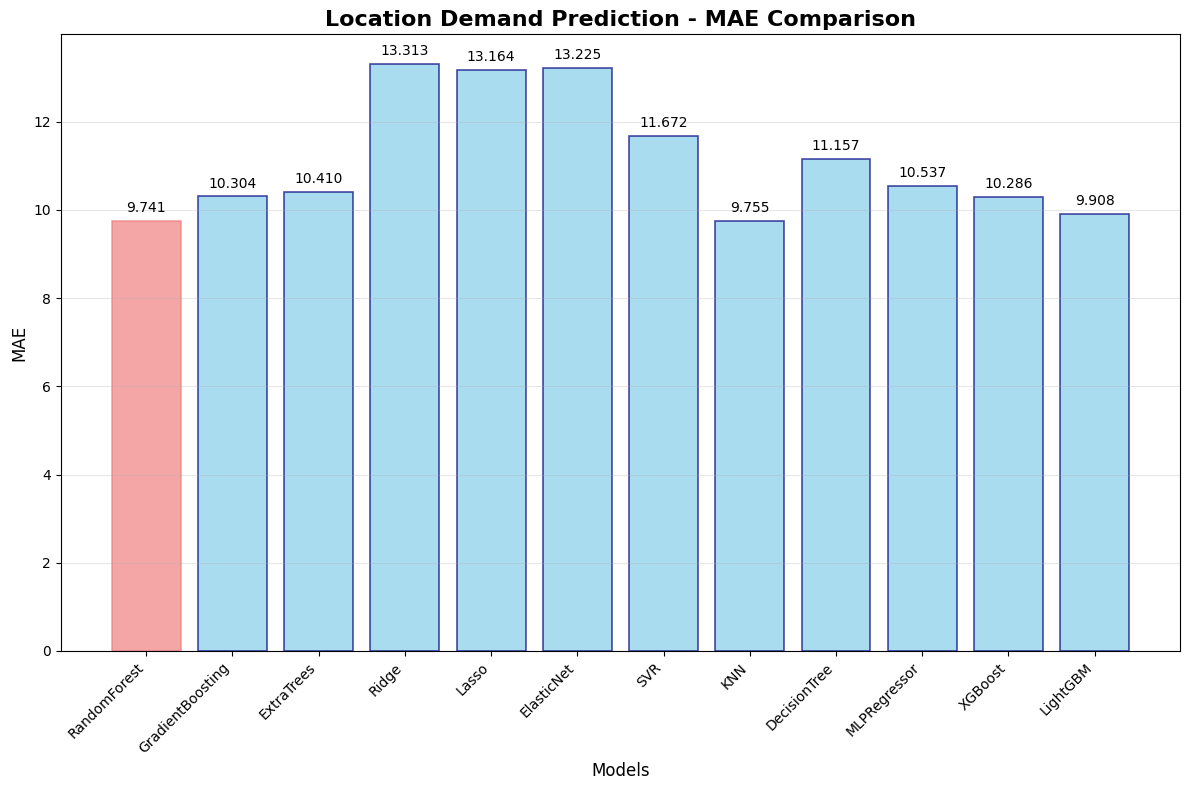

📊 Saved visualization: visualizations/location_demand_prediction_mae_comparison.png


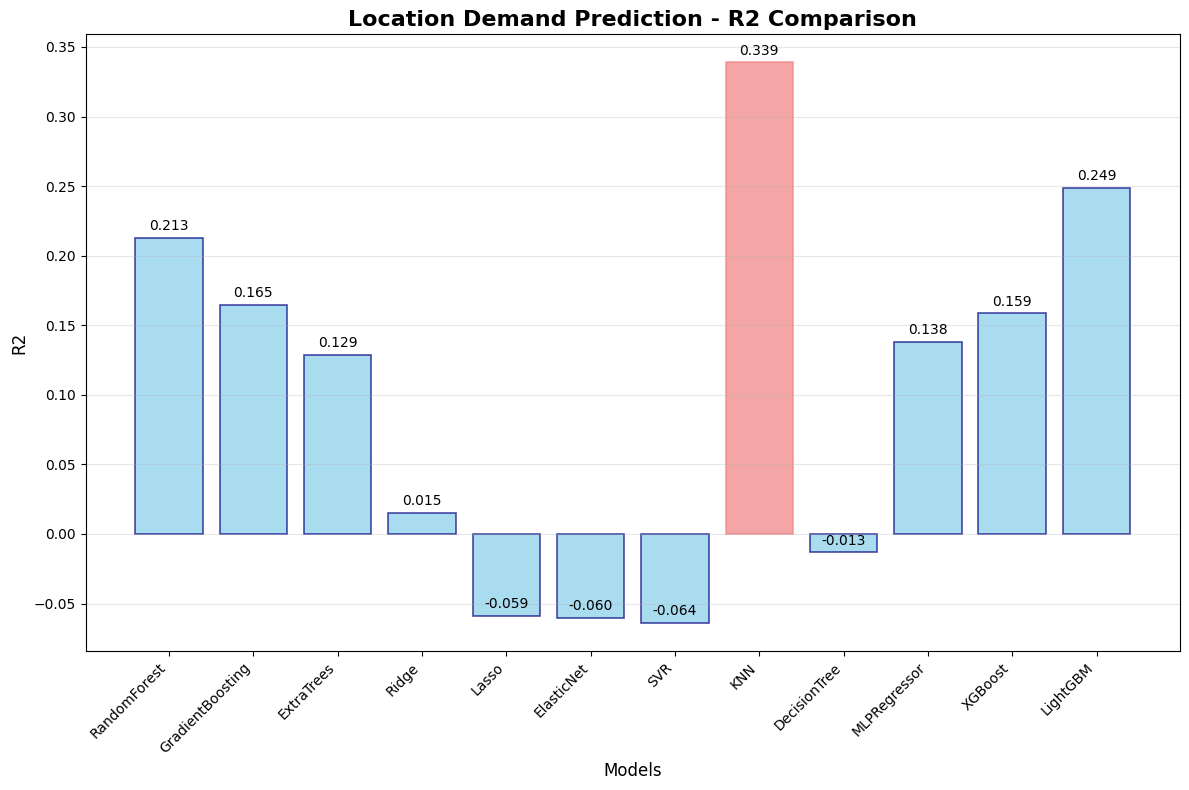

📊 Saved visualization: visualizations/location_demand_prediction_r2_comparison.png

🎯 Task 2: Peak Time Classification

🔄 Evaluating 11 classification models for Peak Time Classification...
📊 RandomForest    - Acc: 0.999, F1: 0.999, Prec: 0.999, Rec: 0.999, Time: 1.59s
📊 GradientBoosting - Acc: 1.000, F1: 1.000, Prec: 1.000, Rec: 1.000, Time: 3.58s
📊 ExtraTrees      - Acc: 0.984, F1: 0.984, Prec: 0.984, Rec: 0.984, Time: 0.89s
📊 LogisticRegression - Acc: 0.856, F1: 0.856, Prec: 0.857, Rec: 0.856, Time: 0.02s
📊 SVC             - Acc: 0.905, F1: 0.906, Prec: 0.912, Rec: 0.905, Time: 20.98s
📊 KNN             - Acc: 1.000, F1: 1.000, Prec: 1.000, Rec: 1.000, Time: 0.31s
📊 NaiveBayes      - Acc: 0.809, F1: 0.807, Prec: 0.808, Rec: 0.809, Time: 0.01s
📊 DecisionTree    - Acc: 1.000, F1: 1.000, Prec: 1.000, Rec: 1.000, Time: 0.03s
📊 MLPClassifier   - Acc: 1.000, F1: 1.000, Prec: 1.000, Rec: 1.000, Time: 8.20s
📊 XGBoost         - Acc: 1.000, F1: 1.000, Prec: 1.000, Rec: 1.000, Time: 0.15s
📊 Lig

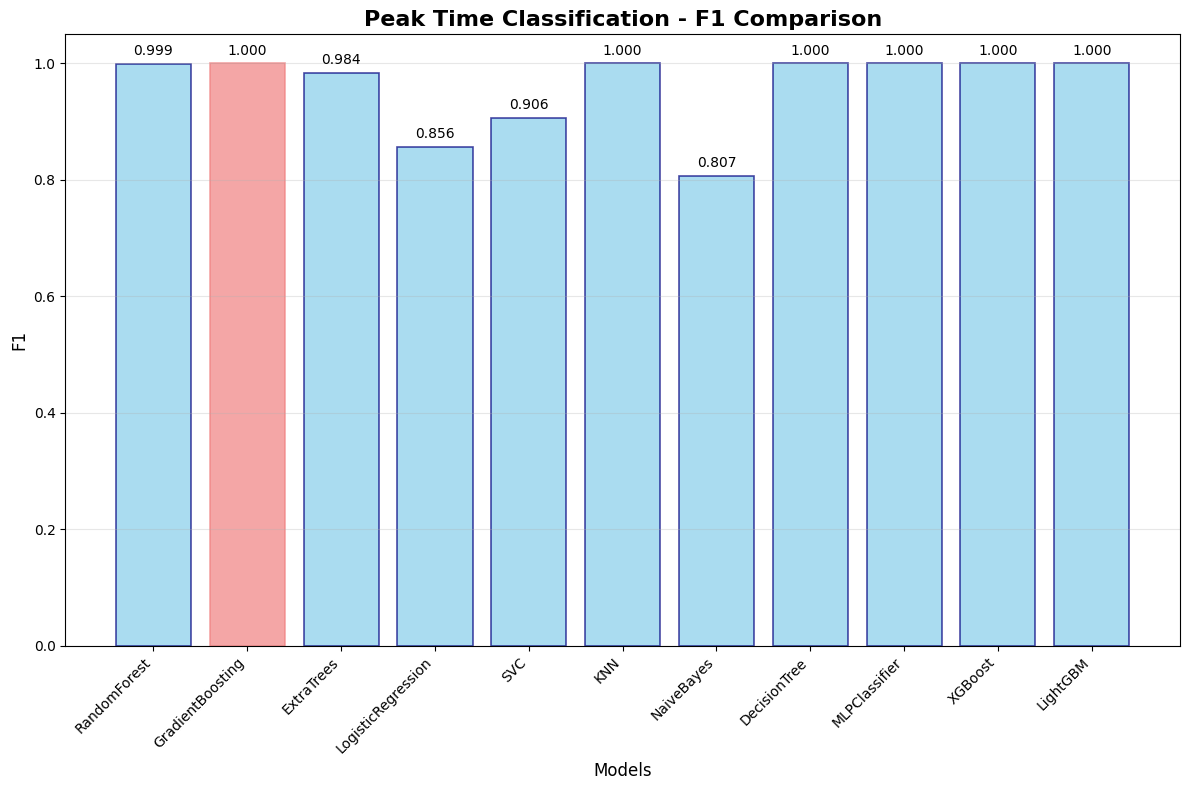

📊 Saved visualization: visualizations/peak_time_classification_f1_comparison.png


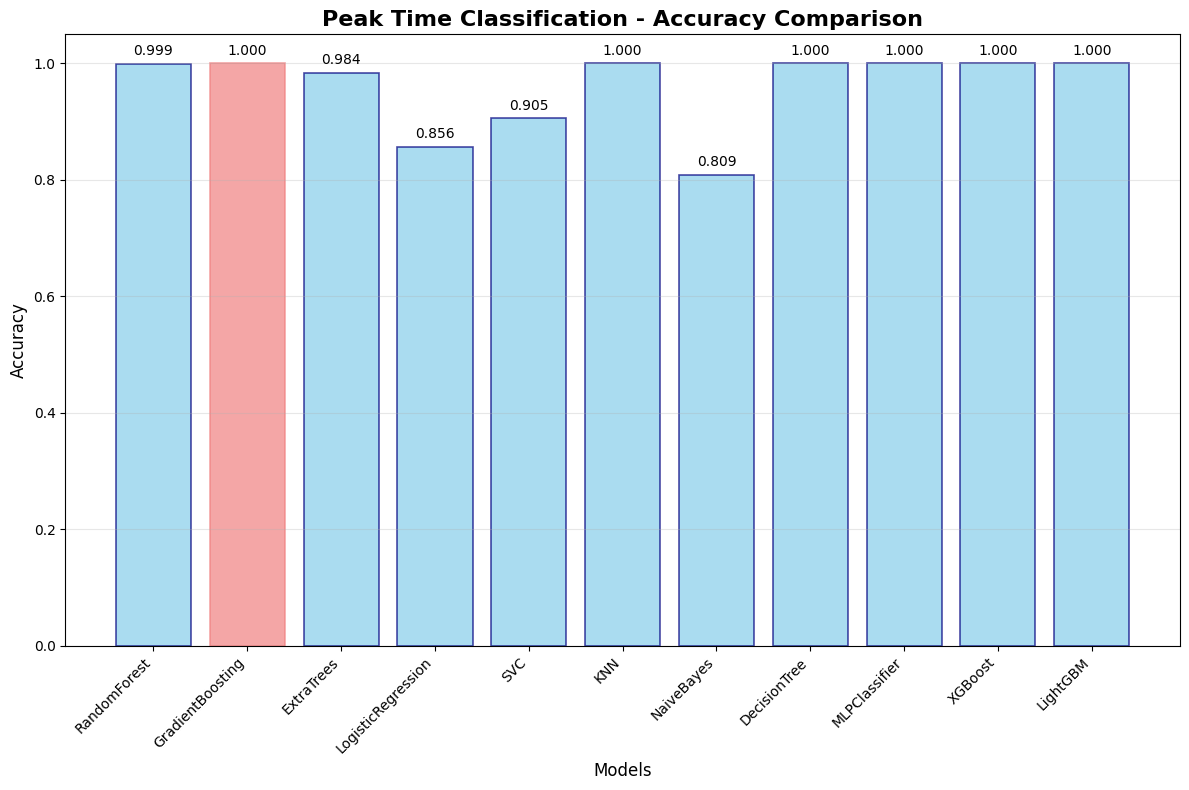

📊 Saved visualization: visualizations/peak_time_classification_accuracy_comparison.png


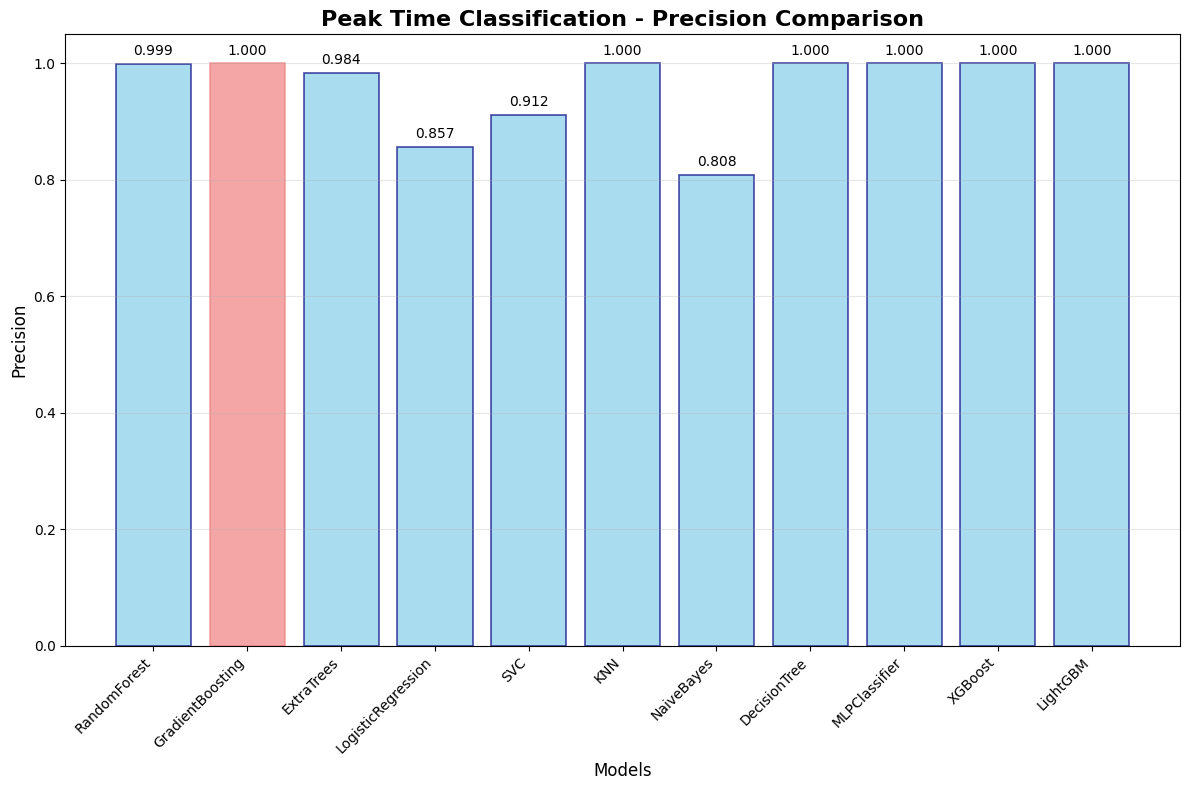

📊 Saved visualization: visualizations/peak_time_classification_precision_comparison.png


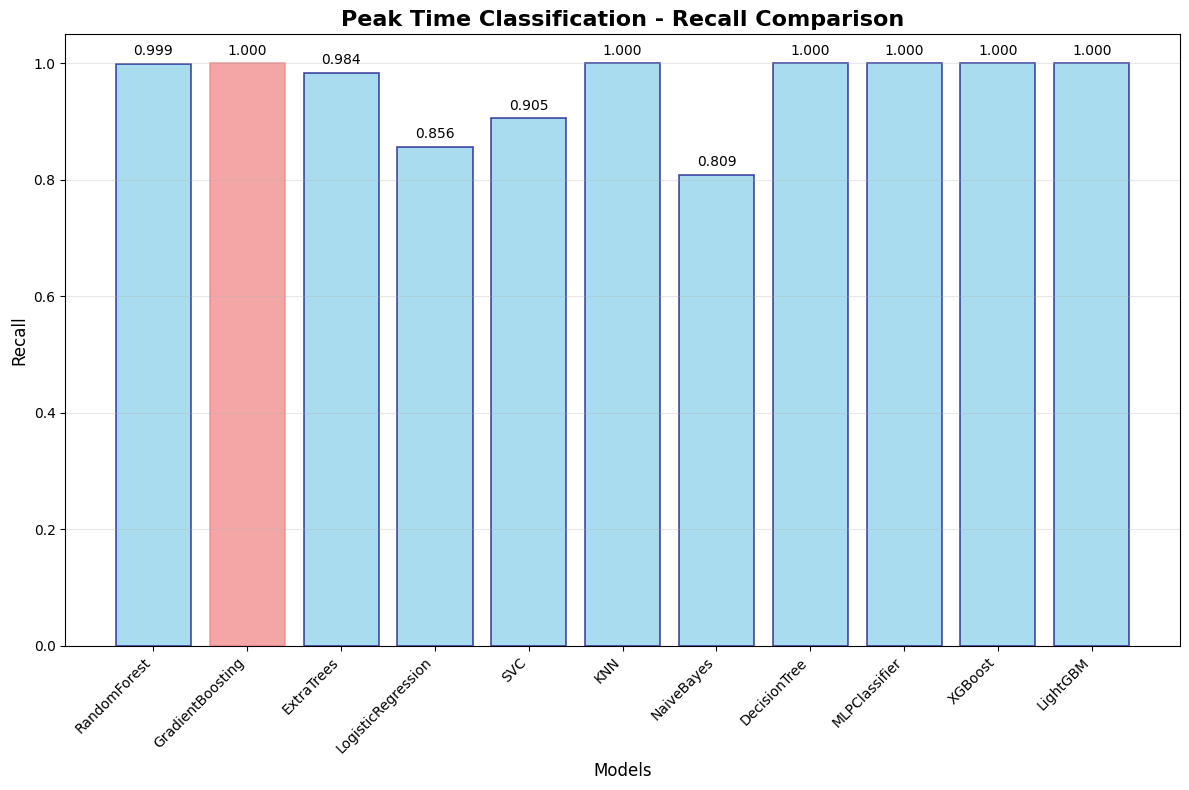

📊 Saved visualization: visualizations/peak_time_classification_recall_comparison.png


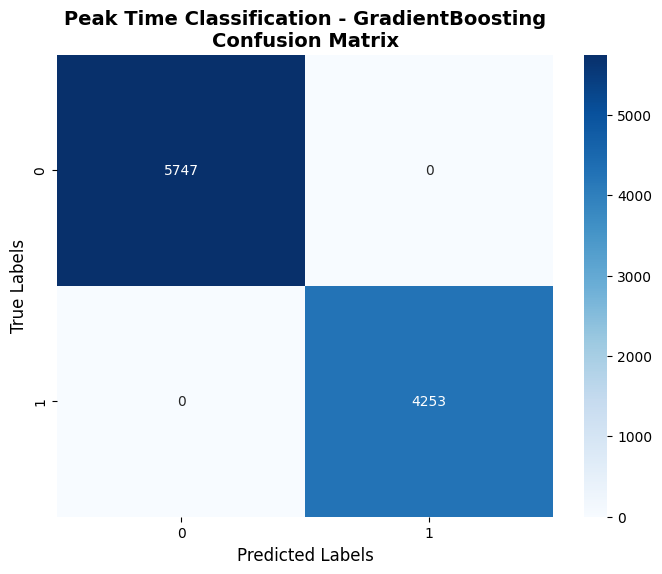

📊 Saved confusion matrix: visualizations/peak_time_classification_gradientboosting_confusion_matrix.png

🎯 Task 3: Dispatching Base Performance Analysis

🔄 Evaluating 11 classification models for Base Performance Analysis...
📊 RandomForest    - Acc: 0.954, F1: 0.954, Prec: 0.953, Rec: 0.954, Time: 0.16s
📊 GradientBoosting - Acc: 0.971, F1: 0.971, Prec: 0.971, Rec: 0.971, Time: 0.83s
📊 ExtraTrees      - Acc: 0.941, F1: 0.941, Prec: 0.940, Rec: 0.941, Time: 0.09s
📊 LogisticRegression - Acc: 0.950, F1: 0.950, Prec: 0.951, Rec: 0.950, Time: 0.03s
📊 SVC             - Acc: 0.950, F1: 0.949, Prec: 0.950, Rec: 0.950, Time: 0.02s
📊 KNN             - Acc: 0.950, F1: 0.949, Prec: 0.949, Rec: 0.950, Time: 0.01s
📊 NaiveBayes      - Acc: 0.920, F1: 0.923, Prec: 0.931, Rec: 0.920, Time: 0.00s
📊 DecisionTree    - Acc: 0.966, F1: 0.967, Prec: 0.967, Rec: 0.966, Time: 0.01s
📊 MLPClassifier   - Acc: 0.912, F1: 0.907, Prec: 0.910, Rec: 0.912, Time: 0.24s
📊 XGBoost         - Acc: 0.975, F1: 0.975, Prec: 0.

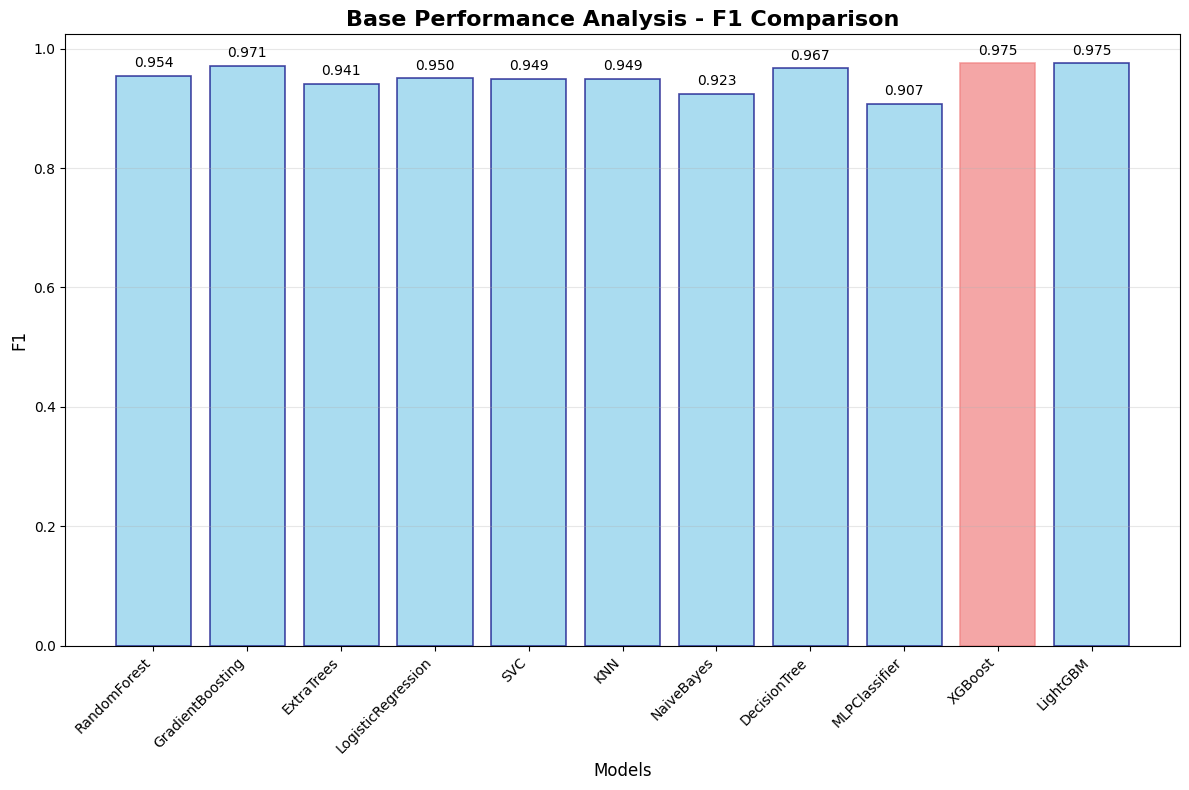

📊 Saved visualization: visualizations/base_performance_analysis_f1_comparison.png


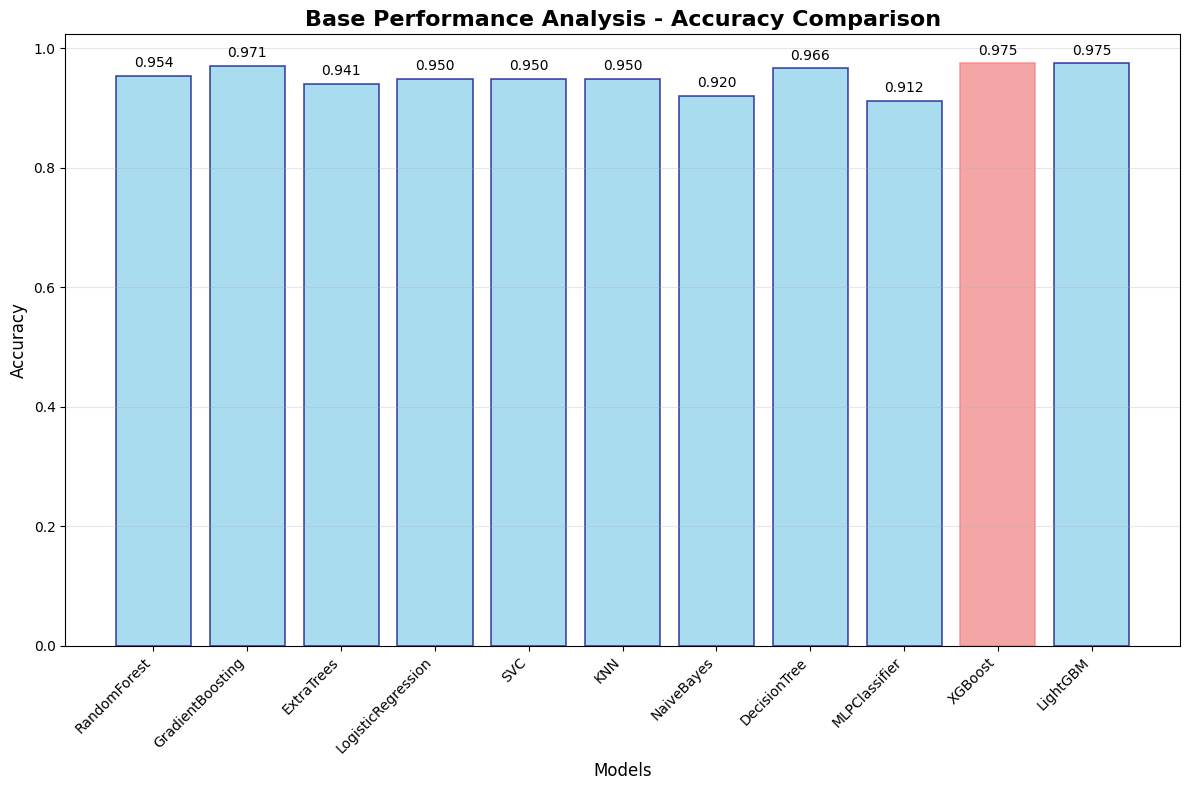

📊 Saved visualization: visualizations/base_performance_analysis_accuracy_comparison.png


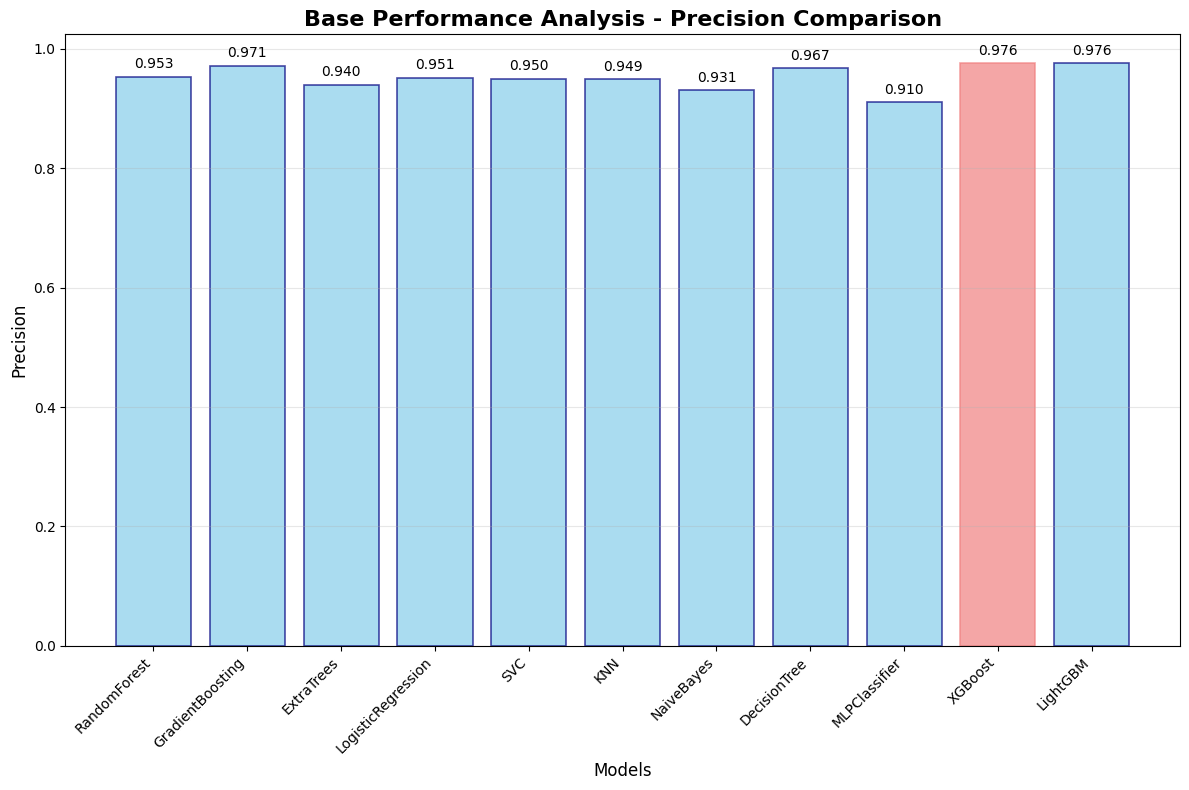

📊 Saved visualization: visualizations/base_performance_analysis_precision_comparison.png


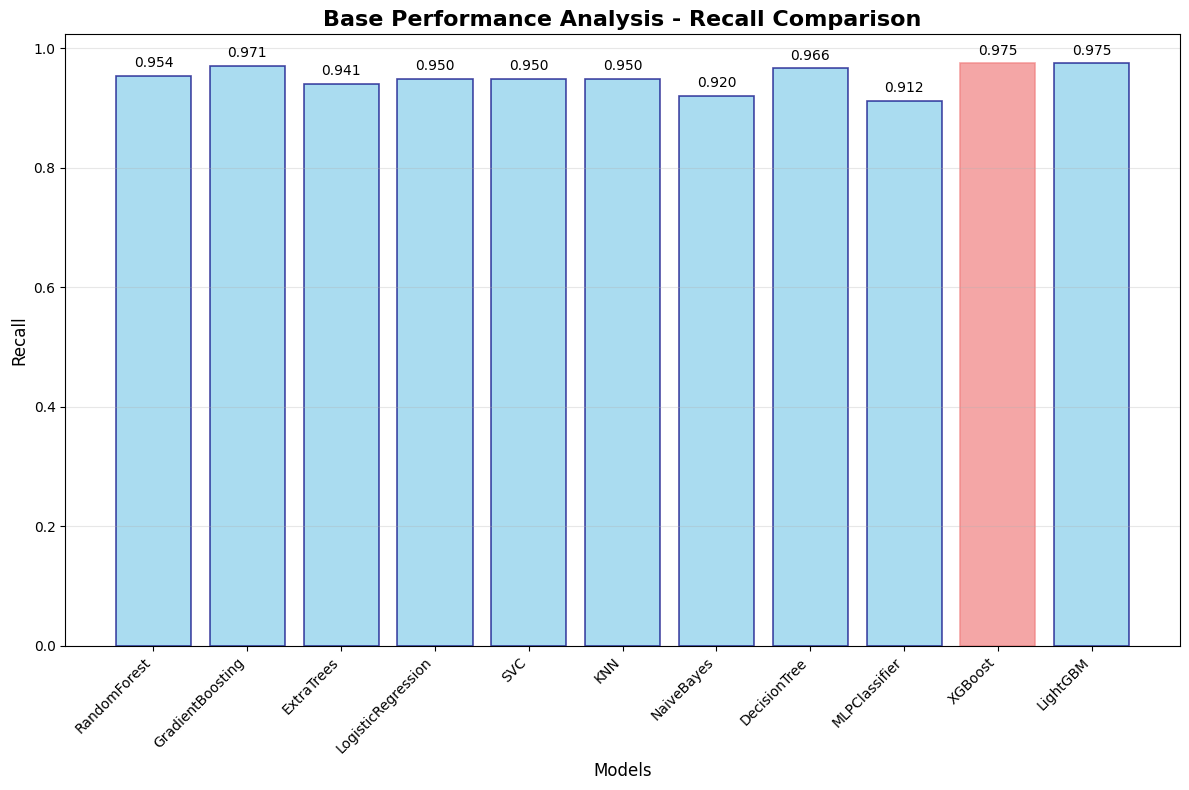

📊 Saved visualization: visualizations/base_performance_analysis_recall_comparison.png


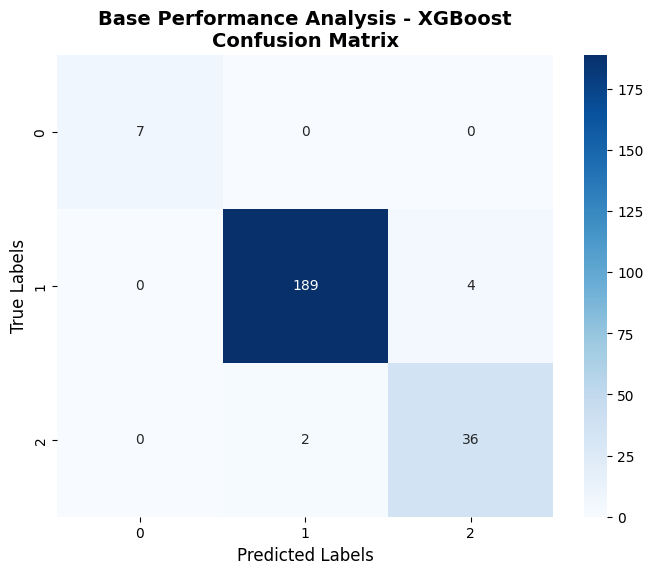

📊 Saved confusion matrix: visualizations/base_performance_analysis_xgboost_confusion_matrix.png

🎯 Task 4: Weather-Demand Correlation Prediction

🔄 Evaluating 12 regression models for Weather-Demand Correlation...
📊 RandomForest    - MAE: 18.775, MSE: 668.935, R²: 0.604, Time: 0.83s
📊 GradientBoosting - MAE: 19.639, MSE: 735.797, R²: 0.564, Time: 0.76s
📊 ExtraTrees      - MAE: 19.724, MSE: 719.483, R²: 0.574, Time: 0.27s
📊 Ridge           - MAE: 23.636, MSE: 999.294, R²: 0.408, Time: 0.00s
📊 Lasso           - MAE: 24.687, MSE: 1107.185, R²: 0.344, Time: 0.00s
📊 ElasticNet      - MAE: 28.610, MSE: 1352.484, R²: 0.199, Time: 0.00s
📊 SVR             - MAE: 24.608, MSE: 1119.161, R²: 0.337, Time: 0.48s
📊 KNN             - MAE: 24.501, MSE: 1085.145, R²: 0.357, Time: 0.02s
📊 DecisionTree    - MAE: 22.250, MSE: 949.713, R²: 0.437, Time: 0.01s
📊 MLPRegressor    - MAE: 20.952, MSE: 758.082, R²: 0.551, Time: 6.36s
📊 XGBoost         - MAE: 19.489, MSE: 704.000, R²: 0.583, Time: 0.07s
📊 LightGBM 

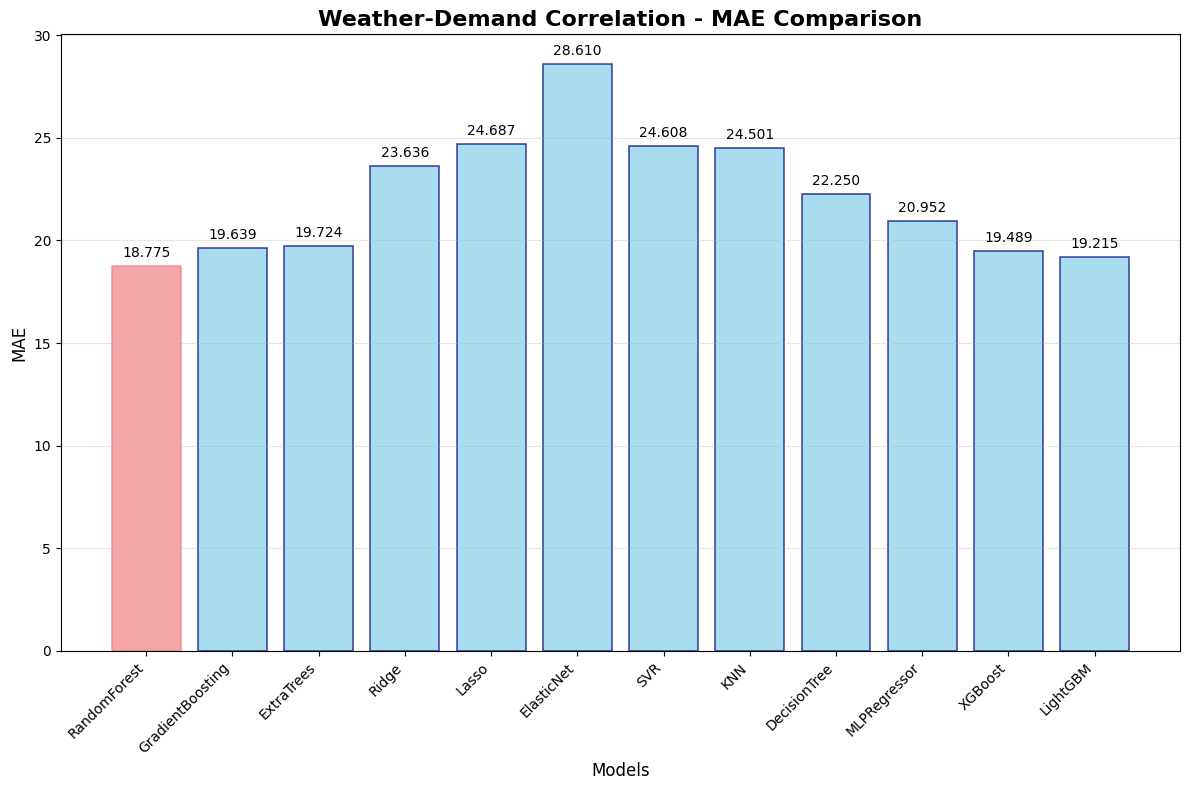

📊 Saved visualization: visualizations/weather-demand_correlation_mae_comparison.png


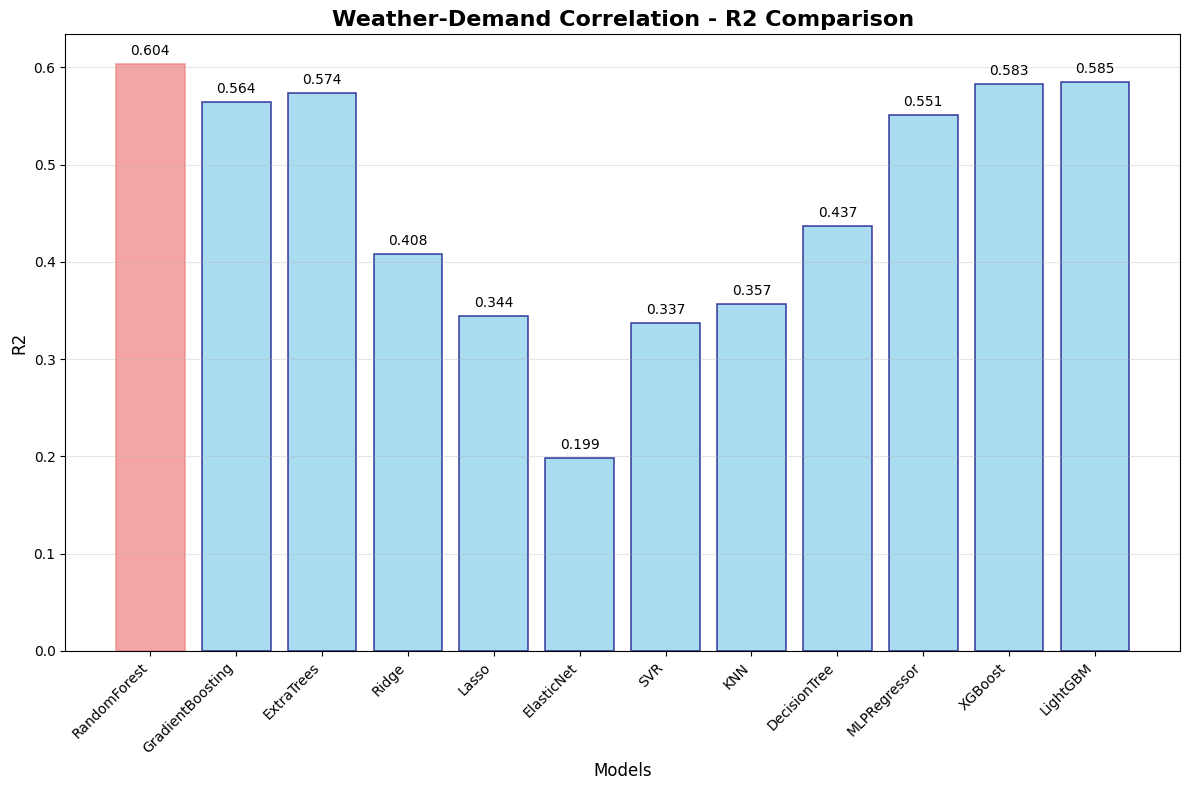

📊 Saved visualization: visualizations/weather-demand_correlation_r2_comparison.png

💾 Saving all models and results...
💾 Saved location_demand - Best Model: RandomForest
💾 Saved peak_time - Best Model: GradientBoosting
💾 Saved base_performance - Best Model: XGBoost
💾 Saved weather_demand - Best Model: RandomForest
✅ Saved 4 best models with performance comparison

🏆 MODEL PERFORMANCE SUMMARY

📊 LOCATION DEMAND
------------------------------------------------------------
Rank | Model           | MAE     | R²      | Time(s)
------------------------------------------------------------
   1 | RandomForest    |   9.741 |   0.213 |    5.81
   2 | KNN             |   9.755 |   0.339 |    0.16
   3 | LightGBM        |   9.908 |   0.249 |    0.10
   4 | XGBoost         |  10.286 |   0.159 |    0.19
   5 | GradientBoosting |  10.304 |   0.165 |    5.47
   6 | ExtraTrees      |  10.410 |   0.129 |    1.11
   7 | MLPRegressor    |  10.537 |   0.138 |   23.98
   8 | DecisionTree    |  11.157 |  -0.

In [44]:
# Run the complete pipeline with multiple model comparison
# This will:
# 1. Load and prepare data
# 2. Run all 4 business tasks
# 3. Compare multiple models for each task
# 4. Select best models based on performance
# 5. Generate visualizations
# 6. Save models and results

pipeline.run_complete_pipeline()

## 11. Results Analysis

After running the pipeline, you can analyze the results:

### Model Performance Files Created:
- `models/model_performance_comparison.json` - Detailed performance metrics for all models
- `models/enhanced_model_metadata.json` - Metadata about best models and features
- `models/*_best_model.joblib` - Saved best models for each task
- `models/*_scaler.joblib` - Saved scalers for each task
- `models/*_encoder.joblib` - Saved encoders for each task

### Visualizations Created:
- Model comparison charts for each metric
- Confusion matrices for classification tasks
- Feature importance plots for tree-based models

### Business Tasks Completed:
1. **Location Demand Prediction** - Regression models compared
2. **Peak Time Classification** - Classification models compared
3. **Dispatching Base Performance Analysis** - Multi-class classification
4. **Weather-Demand Correlation** - Regression with weather features

In [45]:
# Optional: Display performance comparison
print("\n📊 Model Performance Summary:")
for task, performances in pipeline.model_performances.items():
    print(f"\n{task.upper().replace('_', ' ')}:")
    best_model_name = pipeline.best_models[task]['name']
    print(f"  Best Model: {best_model_name}")
    
    if task in ['location_demand', 'weather_demand']:  # Regression
        best_mae = min([perf.get('MAE', float('inf')) for perf in performances.values() if 'Error' not in perf])
        print(f"  Best MAE: {best_mae:.3f}")
    else:  # Classification
        best_f1 = max([perf.get('F1', 0) for perf in performances.values() if 'Error' not in perf])
        print(f"  Best F1: {best_f1:.3f}")

print("\n✅ Pipeline execution completed successfully!")


📊 Model Performance Summary:

LOCATION DEMAND:
  Best Model: RandomForest
  Best MAE: 9.741

PEAK TIME:
  Best Model: GradientBoosting
  Best F1: 1.000

BASE PERFORMANCE:
  Best Model: XGBoost
  Best F1: 0.975

WEATHER DEMAND:
  Best Model: RandomForest
  Best MAE: 18.775

✅ Pipeline execution completed successfully!


## Conclusion

This Enhanced Business ML Pipeline notebook provides:

✅ **Comprehensive Model Comparison**: Tests multiple algorithms for each business task
✅ **Business-Focused Tasks**: Four real-world scenarios based on available data
✅ **Automated Evaluation**: Performance metrics and visualizations for model selection
✅ **Production-Ready**: Saves best models, scalers, and encoders for deployment
✅ **Visualization**: Charts and plots for model comparison and feature analysis

### Next Steps:
1. Analyze the generated visualizations in the `visualizations/` folder
2. Review model performance in the saved JSON files
3. Use the saved models for predictions on new data
4. Fine-tune hyperparameters for the best-performing models
5. Deploy the best models for production use

**Happy Machine Learning! 🚀🎆**